# Load dataset and rescale layers

Square images are more common and convenient for cycleGAN, because they can fit the standard image sizes of 128x128 or 256x256, which are often used for cycleGAN models12. Square images can also avoid distortion or stretching when applying the cycleGAN generator, which can affect the quality and realism of the generated images

In [1]:
"""import tensorflow as tf
from keras.utils import image_dataset_from_directory
from keras.layers import Rescaling

batch_size = 32
img_shape=(128,128,3)

dataset = image_dataset_from_directory(
  'dataset', 
  labels='inferred',  
  image_size=(img_shape[0:2]), 
  shuffle=True,
  seed=123,
  label_mode='binary',
  subset='both',
  validation_split=0.2,
  batch_size=batch_size
)

class_names = dataset[0].class_names

# Create a Rescaling layer
rescale = Rescaling(scale=1./127.5, offset=-1)

new_dataset = []
for i in range(len(dataset)):
  new_dataset.append(dataset[i].map(lambda x, y: (rescale(x), y)).batch(batch_size))

train_a = new_dataset[0].filter(lambda x, y: tf.equal(y, 0))
val_a = new_dataset[1].filter(lambda x, y: tf.equal(y, 0))

train_b = new_dataset[0].filter(lambda x, y: tf.equal(y, 1))
val_b = new_dataset[1].filter(lambda x, y: tf.equal(y, 1))"""


"import tensorflow as tf\nfrom keras.utils import image_dataset_from_directory\nfrom keras.layers import Rescaling\n\nbatch_size = 32\nimg_shape=(128,128,3)\n\ndataset = image_dataset_from_directory(\n  'dataset', \n  labels='inferred',  \n  image_size=(img_shape[0:2]), \n  shuffle=True,\n  seed=123,\n  label_mode='binary',\n  subset='both',\n  validation_split=0.2,\n  batch_size=batch_size\n)\n\nclass_names = dataset[0].class_names\n\n# Create a Rescaling layer\nrescale = Rescaling(scale=1./127.5, offset=-1)\n\nnew_dataset = []\nfor i in range(len(dataset)):\n  new_dataset.append(dataset[i].map(lambda x, y: (rescale(x), y)).batch(batch_size))\n\ntrain_a = new_dataset[0].filter(lambda x, y: tf.equal(y, 0))\nval_a = new_dataset[1].filter(lambda x, y: tf.equal(y, 0))\n\ntrain_b = new_dataset[0].filter(lambda x, y: tf.equal(y, 1))\nval_b = new_dataset[1].filter(lambda x, y: tf.equal(y, 1))"

In [2]:
# Import the libraries
import torch
from tqdm import tqdm
from torchvision import transforms
from torchvision.datasets import ImageFolder

batch_size = 32
img_shape=(128,128,3)

# Define the image transformations
transform = transforms.Compose([
	transforms.Resize(128),
	transforms.CenterCrop(128),
	transforms.ToTensor(),
	# rescale an image from [0, 255] to [-1, 1]
	transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# Load the datasets
dataset = ImageFolder("dataset", transform=transform)

# Get the class labels for the dataset
class_labels = dataset.classes

# Initialize two lists to store the indices of the images in each class
closed_eyes_indices = []
open_eyes_indices = []

# Loop through the dataset to get the indices of the images in each class
for i in tqdm(range(len(dataset))):
	# Get the class label for the current image
	label = dataset[i][1]
	
	# Add the index to the appropriate list based on the class label
	if label == 0:
		closed_eyes_indices.append(i)
	else:
		open_eyes_indices.append(i)

class UnlabeledSubset(torch.utils.data.Subset):
	def __getitem__(self, idx):
		return self.dataset[self.indices[idx]][0] # return only the image

# Create two subsets of the dataset, one for each class
dataset_closed_eyes = UnlabeledSubset(dataset, closed_eyes_indices)
dataset_open_eyes = UnlabeledSubset(dataset, open_eyes_indices)

# Create the data loaders
dataloader_closed_eyes = torch.utils.data.DataLoader(dataset_closed_eyes, batch_size=batch_size, shuffle=True, num_workers=4)
dataloader_open_eyes = torch.utils.data.DataLoader(dataset_open_eyes, batch_size=batch_size, shuffle=True, num_workers=4)

100%|██████████| 9200/9200 [00:16<00:00, 558.01it/s]


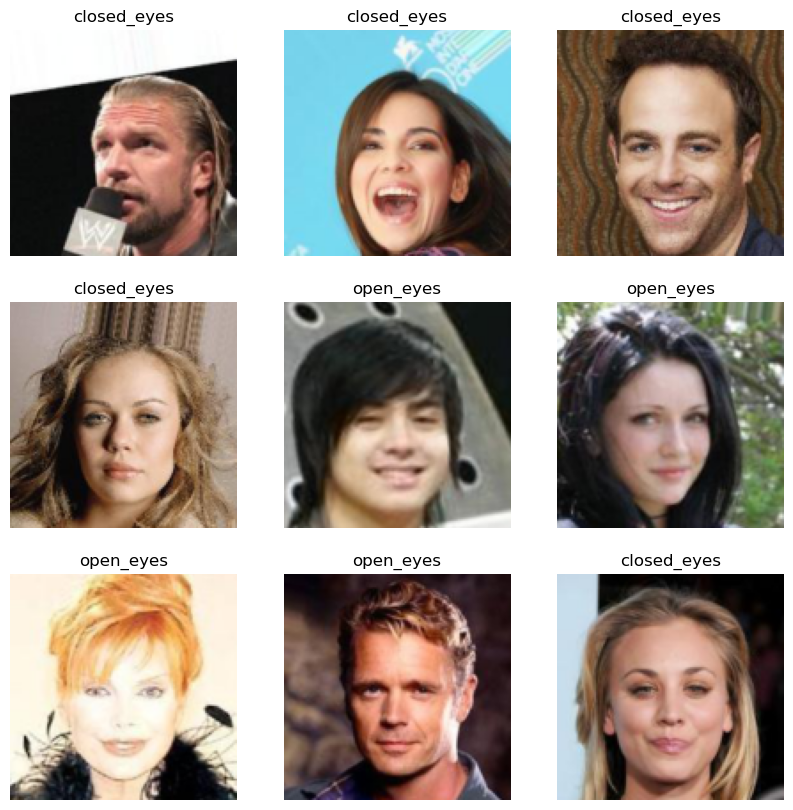

In [3]:
import matplotlib.pyplot as plt
import random

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
])

# Load the datasets
real_dataset = ImageFolder("dataset", transform=transform)


# Plot the images and the labels
plt.figure(figsize=(10, 10))

for i in range(9):
    # Get the image and the label at the i-th position
    index = random.randint(0, len(real_dataset))
    image = real_dataset[index][0]
    label = real_dataset[index][1]
    # Create a subplot for the image
    ax = plt.subplot(3, 3, i + 1)
    # Display the image
    plt.imshow(image)
    # Turn off the axes
    plt.axis("off")
    # Display the label as the title
    plt.title(class_labels[label])
# Show the plot
plt.show()

# Build the generator and discriminator of the CycleGAN
### Generator
- better use an img_shape, insted of a noise_shape(100,), as the input layers since it is common for the generator to have an input layer that has the same shape as the images in one of the domains, rather than a noise layer with a fixed size
- the number of filters used in each layer and the stride size have been chosen as a popular implementation
- BatchNormalization is a normalization layer applied to the activations of the previous layer, which helps to reduce the internal covariate shift, resulting in faster convergence. The value of 0.8 for the momentum has been chosen to ensure that the running mean and variance are updated with a balance of stability and responsiveness to changes in the activations.
- the 'relu' activation function in the Conv2DTranspose helps to introduce non-linearity into the model, but it does not used because the generator is designed to generate images that span the full range of pixel values, which is not possible with the ReLU activation, which clips the values to be non-negative
- the activation function used in the last Conv2D layer is 'tanh', which gives the output values in the range of -1 to 1. This is usually done to ensure that the generated images have pixel values in a range that is more suitable for image generation.

### Discriminator
- uses LeakyReLU activations instead of standard ReLU activations, which allows it to better handle the rare cases where the input may be negative.
- uses a sigmoid activation function in its output layer to produce a probability that the input image is real (i.e., from the target domain).
- uses BatchNormalization layers to normalize the activations between layers and help stabilize the training process.

In [4]:
from keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Flatten, Dense
from keras.models import Model

def build_generator(img_shape):
	input_layer = Input(shape=img_shape)
	x = Conv2D(64, (3,3), strides=(2,2), padding='same')(input_layer)
	x = LeakyReLU(alpha=0.2)(x)
	x = Conv2D(128, (3,3), strides=(2,2), padding='same')(x)
	x = BatchNormalization(momentum=0.8)(x)
	x = LeakyReLU(alpha=0.2)(x)
	x = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(x)
	x = BatchNormalization(momentum=0.8)(x)
	x = LeakyReLU(alpha=0.2)(x)
	x = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same')(x)
	x = BatchNormalization(momentum=0.8)(x)
	x = LeakyReLU(alpha=0.2)(x)
	x = Conv2D(3, (3,3), padding='same', activation='tanh')(x)
	return Model(inputs=input_layer, outputs=x)

def build_discriminator(img_shape) -> Model:
	input_layer = Input(shape=img_shape)
	x = Conv2D(32, (3,3), strides=(2,2), padding='same')(input_layer)
	x = LeakyReLU(alpha=0.2)(x)
	x = Conv2D(64, (3,3), strides=(2,2), padding='same')(x)
	x = BatchNormalization(momentum=0.8)(x)
	x = LeakyReLU(alpha=0.2)(x)
	x = Conv2D(128, (3,3), strides=(2,2), padding='same')(x)
	x = BatchNormalization(momentum=0.8)(x)
	x = LeakyReLU(alpha=0.2)(x)
	x = Conv2D(256, (3,3), strides=(2,2), padding='same')(x)
	x = BatchNormalization(momentum=0.8)(x)
	x = LeakyReLU(alpha=0.2)(x)
	x = Flatten()(x)
	x = Dense(1, activation='sigmoid')(x)
	return Model(inputs=input_layer, outputs=x)

generator = build_generator(img_shape=img_shape)
discriminator = build_discriminator(img_shape=img_shape)

# Compile the models

input_A and input_B are the inputs to the CycleGAN, representing images from domains A and B, respectively. The generator_A2B and generator_B2A models are used to generate synthetic images in the other domain, while the discriminator_A and discriminator_B models are used to predict whether images are real or fake. The reconstructed_A and reconstructed_B tensors represent the reconstructed images, which are used in the cycle consistency loss. The prediction_real_A, prediction_real_B, prediction_fake_A, and prediction_fake_B tensors represent the predictions of the discriminators, which are used in the adversarial loss. The full model, cyclegan, is used for training the generator.

In [ ]:
def build_cyclegan(generator_A2B, generator_B2A, discriminator_A, discriminator_B, img_shape):
	input_A = Input(shape=img_shape)
	input_B = Input(shape=img_shape)

	generated_B = generator_A2B(input_A)
	generated_A = generator_B2A(input_B)

	reconstructed_A = generator_B2A(generated_B)
	reconstructed_B = generator_A2B(generated_A)

	# Discriminators predict whether images are real or fake
	prediction_real_A = discriminator_A(input_A)
	prediction_real_B = discriminator_B(input_B)
	prediction_fake_A = discriminator_A(generated_A)
	prediction_fake_B = discriminator_B(generated_B)

	# Full model for training generator
	cyclegan = Model([input_A, input_B], [prediction_real_A, prediction_real_B, prediction_fake_A, prediction_fake_B, reconstructed_A, reconstructed_B])
	return cyclegan

cyclegan = build_cyclegan(
  generator_A2B=generator, 
  generator_B2A=generator,
  discriminator_A=discriminator,
  discriminator_B=discriminator,
  img_shape=img_shape
)

# Train the models
- A Wasserstein loss, also known as the Earth Mover's Distance (EMD), is commonly used in GANs to stabilize the training process and improve the quality of generated samples. The Wasserstein loss is defined as the minimum amount of "work" needed to transform the generated data distribution to match the real data distribution. In contrast, the BinaryCrossentropy loss is used for binary classification problems and is less commonly used for GANs.


In [5]:
import tensorflow as tf
import keras
from keras.losses import BinaryCrossentropy

@tf.function
def train_step(generator_A, generator_B, discriminator_A, discriminator_B, batch_A, batch_B):
	with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
		fake_B = generator_A(batch_A, training=True)
		fake_A = generator_B(batch_B, training=True)

		real_output_A = discriminator_A(batch_A, training=True)
		fake_output_A = discriminator_A(fake_A, training=True)
		real_output_B = discriminator_B(batch_B, training=True)
		fake_output_B = discriminator_B(fake_B, training=True)

		cycle_loss = tf.reduce_mean(tf.abs(batch_A - generator_B(fake_B))) + tf.reduce_mean(tf.abs(batch_B - generator_A(fake_A)))
		generator_loss = -tf.reduce_mean(fake_output_A) - tf.reduce_mean(fake_output_B)
		discriminator_loss_A = -tf.reduce_mean(real_output_A) + tf.reduce_mean(fake_output_A)
		discriminator_loss_B = -tf.reduce_mean(real_output_B) + tf.reduce_mean(fake_output_B)

		total_loss = generator_loss + cycle_loss
		
	generator_gradients = generator_tape.gradient(total_loss, generator_A.trainable_variables + generator_B.trainable_variables)
	discriminator_gradients_A = discriminator_tape.gradient(discriminator_loss_A, discriminator_A.trainable_variables)
	discriminator_gradients_B = discriminator_tape.gradient(discriminator_loss_B, discriminator_B.trainable_variables)

	return generator_loss, discriminator_loss_A, discriminator_loss_B, cycle_loss, generator_gradients, discriminator_gradients_A, discriminator_gradients_B

def train(generator_A, generator_B, discriminator_A, discriminator_B, dataset_A, dataset_B, epochs=100):
	optimizer_discriminator_A = keras.optimizers.Adam(5e-4)
	optimizer_discriminator_B = keras.optimizers.Adam(5e-4)
	optimizer_generator = keras.optimizers.Adam(5e-4)

	#summary_writer = tf.summary.create_file_writer('logs')

	for epoch in tqdm(range(epochs), desc="epochs"):
		for batch_A, batch_B in tqdm(zip(dataset_A, dataset_B), desc="batches"):
			generator_loss, discriminator_loss_A, discriminator_loss_B, cycle_loss, generator_gradients, discriminator_gradients_A, discriminator_gradients_B = train_step(generator_A, generator_B, discriminator_A, discriminator_B, batch_A, batch_B)

			optimizer_discriminator_A.apply_gradients(zip(discriminator_gradients_A, discriminator_A.trainable_variables))
			optimizer_discriminator_B.apply_gradients(zip(discriminator_gradients_B, discriminator_B.trainable_variables))
			optimizer_generator.apply_gradients(zip(generator_gradients, generator_A.trainable_variables + generator_B.trainable_variables))

		"""with summary_writer.as_default():
			tf.summary.scalar("generator_loss", generator_loss, step=epoch)
			tf.summary.scalar("discriminator_loss_A", discriminator_loss_A, step=epoch)
			tf.summary.scalar("discriminator_loss_B", discriminator_loss_B, step=epoch)
			tf.summary.scalar("cycle_loss", cycle_loss, step=epoch)"""

train(generator_A=generator, generator_B=generator, discriminator_A=discriminator, discriminator_B=discriminator, dataset_B=dataloader_open_eyes, dataset_A=dataloader_closed_eyes, epochs=5)

epochs:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
import tensorflow as tf

@tf.function
def train(generator_A:Model, generator_B:Model, discriminator_A:Model, discriminator_B:Model, dataset_A, dataset_B, epochs=100):
	# Define the loss functions for the generators and discriminators
	generator_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
	discriminator_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

	# Define the optimizers for the generators and discriminators
	optimizer_discriminator_A = tf.keras.optimizers.Adam(1e-4)
	optimizer_discriminator_B = tf.keras.optimizers.Adam(1e-4)
	optimizer_generator = tf.keras.optimizers.Adam(1e-4)
	for epoch in tqdm(range(epochs), desc="Epochs"):
		for batch_A, batch_B in tqdm(zip(dataset_A, dataset_B), desc="Batches"):
			# Generate fake images from the real ones
			fake_B = generator_A(batch_A)
			fake_A = generator_B(batch_B)

			# Compute the discriminator outputs for real and fake images
			real_output_A = discriminator_A(batch_A)
			fake_output_A = discriminator_A(fake_A)
			real_output_B = discriminator_B(batch_B)
			fake_output_B = discriminator_B(fake_B)

			# Compute the generator and discriminator losses
			generator_loss = generator_loss_fn(tf.ones_like(fake_output_A), fake_output_A) + generator_loss_fn(tf.ones_like(fake_output_B), fake_output_B)
			discriminator_loss_A = discriminator_loss_fn(tf.ones_like(real_output_A), real_output_A) + discriminator_loss_fn(tf.zeros_like(fake_output_A), fake_output_A)
			discriminator_loss_B = discriminator_loss_fn(tf.ones_like(real_output_B), real_output_B) + discriminator_loss_fn(tf.zeros_like(fake_output_B), fake_output_B)

			# Compute the cycle consistency loss
			cycle_loss = tf.reduce_mean(tf.abs(batch_A - generator_B(fake_B))) + tf.reduce_mean(tf.abs(batch_B - generator_A(fake_A)))

			# Compute the total loss
			total_loss = generator_loss + cycle_loss

			# Update the generator and discriminator parameters using gradient descent
			generator_gradients = tf.gradients(total_loss, generator_A.trainable_variables + generator_B.trainable_variables)
			discriminator_gradients_A = tf.gradients(discriminator_loss_A, discriminator_A.trainable_variables)
			discriminator_gradients_B = tf.gradients(discriminator_loss_B, discriminator_B.trainable_variables)
			optimizer_generator.apply_gradients(zip(generator_gradients, generator_A.trainable_variables + generator_B.trainable_variables))
			optimizer_discriminator_A.apply_gradients(zip(discriminator_gradients_A, discriminator_A.trainable_variables))
			optimizer_discriminator_B.apply_gradients(zip(discriminator_gradients_B, discriminator_B.trainable_variables))

			# Print the losses for each epoch
			print(f"Epoch {epoch}, Generator loss: {generator_loss}, Discriminator loss A: {discriminator_loss_A}, Discriminator loss B: {discriminator_loss_B}, Cycle loss: {cycle_loss}")
   
	# Save the models
	generator_A.save("models/generator_A")
	generator_B.save("models/generator_B")
	discriminator_A.save("models/discriminator_A")
	discriminator_B.save("models/discriminator_B")
	#cyclegan.save("models/cyclegan")
	"""# Load the models
	generator_A = tf.keras.models.load_model("generator_A")
	generator_B = tf.keras.models.load_model("generator_B")
	discriminator_A = tf.keras.models.load_model("discriminator_A")
	discriminator_B = tf.keras.models.load_model("discriminator_B")
	cyclegan = tf.keras.models.load_model("cyclegan")"""


train(generator, generator, discriminator, discriminator, dataloader_open_eyes, dataloader_closed_eyes, 5)
